In [2]:
import ROOT
import uproot
import numpy as np
import matplotlib.pyplot as plt

In [3]:
fileptr = uproot.open("/scratch/brown/bakshi3/TopSpinCorr_Run2_generalized_ND/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/UnfoldingHistos_2016preVFP/Nominal/emu/histosTUnfold_emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP.root")

In [4]:
hgen_c_kk = fileptr["hgen_c_kk"].to_numpy()[0]

In [5]:
hgen_c_kk

array([ 1077464.25183582,  3368550.09085369,  5856384.09182064,
        8634965.47184265, 11773019.09499021, 15370609.24163127,
       19534762.27027296, 24613794.31064249, 30974864.05966803,
       39398333.686797  , 52612931.28271621, 87278118.39989837,
       87278118.39989837, 52612931.28271621, 39398333.686797  ,
       30974864.05966803, 24613794.31064249, 19534762.27027296,
       15370609.24163127, 11773019.09499021,  8634965.47184265,
        5856384.09182064,  3368550.09085369,  1077464.25183582])

In [6]:
# binFileName = "/depot/cms/top/bakshi3/TopSpinCorr_Run2_generalized_ND/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/binning/c_kk_binning.xml"
# parser = ROOT.TDOMParser()
# parser.ParseFile(binFileName)

# XMLdocument      = parser.GetXMLDocument();
# detectorBinning  = ROOT.TUnfoldBinningXML.ImportXML(XMLdocument,"detector");
# generatorBinning = ROOT.TUnfoldBinningXML.ImportXML(XMLdocument,"generator");

In [8]:
binFileName = "/depot/cms/top/bakshi3/TopSpinCorr_Run2_generalized_ND/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/binning/c_kk_binning_rebinnedB.xml"
parser = ROOT.TDOMParser()
parser.ParseFile(binFileName)

XMLdocument      = parser.GetXMLDocument();
generatorBinning = ROOT.TUnfoldBinningXML.ImportXML(XMLdocument,"generator_rebinnedB");
binning          = generatorBinning.FindNode("ttbargen_rebinnedB");

In [28]:
# Calculate the number of bins along spin coefficient distribution and other dimensions
coefficientName = "c_kk_mttbar"

nbinsX  = 0
numBins = 1

for i in range(binning.GetDistributionDimension()) :
    vec_binEdges = binning.GetDistributionBinning(i)
    
    if (i == 0) :  # 0th distribution is the spin correlation variable
        nbinsX = vec_binEdges.GetNoElements() - 1;

    else :         # number of bins of the other dimensions
        numBins *= vec_binEdges.GetNoElements() - 1

# copy bin edges because they are const doubles currently which ruins everything
xBinEdges = np.zeros(nbinsX + 1)

for i in range(nbinsX + 1) :
    xBinEdges[i] = binning.GetDistributionBinning(0).GetMatrixArray()[i];

print("Bin factor function = [")

# compute and store the BFF
for i in range(numBins) :
    binOffset = i * nbinsX

    # analytic functions for BinFactorFunctions
    # and calculate oneOverSMdensity_sym analytically
    
    symmetrizedSMDensityFunction = ""
    if 'c_' in coefficientName :
        symmetrizedSMDensityFunction = "-log(abs(x))"
    else: 
        symmetrizedSMDensityFunction = "1"


    # SMdensity_sym = ROOT.TF1("SMdensity_sym", symmetrizedSMDensityFunction, xBinEdges[0], xBinEdges[nbinsX + 1])

    oneOverSMdensity     = np.zeros(nbinsX)
    oneOverSMdensity_sym = np.zeros(nbinsX)

    gen_sum = 0.

    for j in range(nbinsX) :
        jthBinWidth    =  xBinEdges[j + 1] - xBinEdges[j];
        genyield       =  hgen_c_kk[binOffset + j + 1]
        gendensity     =  hgen_c_kk[binOffset + j + 1] / jthBinWidth

        gendensity_sym = 0.5 * (hgen_c_kk[binOffset + j + 1] / jthBinWidth
                              + hgen_c_kk[binOffset + nbinsX - j] / (xBinEdges[nbinsX - j] - xBinEdges[nbinsX - j - 1]))

        oneOverSMdensity[j]     = 1. / gendensity;
        oneOverSMdensity_sym[j] = 1. / gendensity_sym;
        gen_sum += genyield;
    
        print("")
        print("jthBinWidth :: "    + str(jthBinWidth))
        print("genyield :: "       + str(genyield))
        print("gendensity :: "     + str(gendensity))
        print("gendensity_sym :: " + str(gendensity_sym))
        print("")
    print(oneOverSMdensity)
    print(oneOverSMdensity_sym)
        
    
    oneOverSMdensity     *= gen_sum / 2
    oneOverSMdensity_sym *= gen_sum / 2

#     SMdensity_sym->SetNpx(10000 * nbinsX);
#     TH1D* SMdensity_sym_histo = (TH1D*)SMdensity_sym->GetHistogram();
#     SMdensity_sym_histo->Rebin(10000);
#     SMdensity_sym_histo->Scale(0.0001);

#     if (MatrixUnf::isCtype(coefficientName) || MatrixUnf::isCPMtype(coefficientName) ||
#         MatrixUnf::isBtype(coefficientName) || MatrixUnf::isDtype(coefficientName)   ||
#         MatrixUnf::isBPMtype(coefficientName)) {
#       for (int j = 0; j < nbinsX; ++j) {
#         if (SMdensity_sym_histo->GetBinContent(j + 1) == 0) {
#           std::cout << "Error, bin content = 0 and trying to divide by 0." << std::endl;
#         }
#         oneOverSMdensity_sym(j) = 1. / SMdensity_sym_histo->GetBinContent(j + 1);
#       }
#     }

#    for (int j = 0; j < nbinsX; ++j) {
#         (*BFFvec)(binOffset + j) = oneOverSMdensity_sym(j);
#         std::cout << " " << oneOverSMdensity_sym(j);
#       }
#     } 
#     }
#     std::cout << " ]" << std::endl;

Bin factor function = [

jthBinWidth :: 0.333333
genyield :: 3368550.090853691
gendensity :: 10105660.378221452
gendensity_sym :: 34355002.89669287


jthBinWidth :: 0.333333
genyield :: 5856384.091820642
gendensity :: 17569169.844631772
gendensity_sym :: 31840521.840699703


jthBinWidth :: 0.333333
genyield :: 8634965.471842647
gendensity :: 25904922.32045026
gendensity_sym :: 30612007.46225674


jthBinWidth :: 0.333333
genyield :: 11773019.094990205
gendensity :: 35319092.60406322
gendensity_sym :: 30612007.46225674


jthBinWidth :: 0.3333330000000001
genyield :: 15370609.24163127
gendensity :: 46111873.83676763
gendensity_sym :: 31840521.840699703


jthBinWidth :: 0.3333329999999999
genyield :: 19534762.270272955
gendensity :: 58604345.4151643
gendensity_sym :: 34355002.89669287

[9.89544436e-08 5.69178856e-08 3.86027021e-08 2.83132982e-08
 2.16863883e-08 1.70635811e-08]
[2.91078421e-08 3.14065204e-08 3.26669200e-08 3.26669200e-08
 3.14065204e-08 2.91078421e-08]


In [29]:
binning.GetDistributionBinning(0).GetMatrixArray()[6]

0.9999979999999999

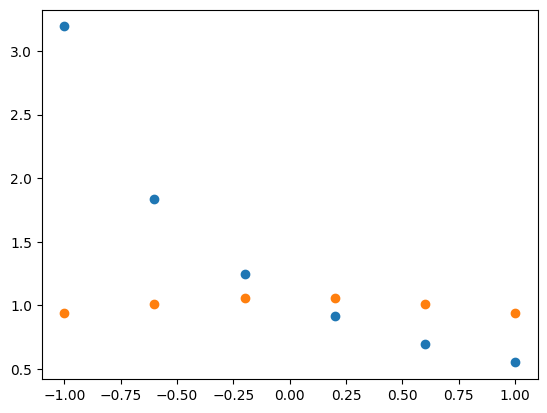

In [30]:
plt.scatter(np.linspace(-1,1,6), oneOverSMdensity)
plt.scatter(np.linspace(-1,1,6), oneOverSMdensity_sym)

In [18]:
xBinEdges[nbinsX ] - xBinEdges[0]

1.999998

In [63]:
xBinEdges[6]

0.9999979999999999

In [60]:
symmetrizedSMDensityFunction = "-log(abs(x))"
SMdensity_sym = ROOT.TF1("SMdensity_sym", symmetrizedSMDensityFunction, xBinEdges[0], xBinEdges[nbinsX +1])

IndexError: index 7 is out of bounds for axis 0 with size 7

In [33]:
SMdensity_sym.SetNpx(10000 * nbinsX);
SMdensity_sym_histo = SMdensity_sym.GetHistogram();

SMdensity_sym_histo.Rebin(10000);
SMdensity_sym_histo.Scale(0.0001);

IncrementalExecutor::executeFunction: symbol '_ZN5cling7runtime6gClingE' unresolved while linking [cling interface function]!
You are probably missing the definition of cling::runtime::gCling
Maybe you need to load the corresponding shared library?
IncrementalExecutor::executeFunction: symbol '_ZN5cling7runtime6gClingE' unresolved while linking [cling interface function]!
You are probably missing the definition of cling::runtime::gCling
Maybe you need to load the corresponding shared library?
IncrementalExecutor::executeFunction: symbol '_ZN5cling7runtime6gClingE' unresolved while linking [cling interface function]!
You are probably missing the definition of cling::runtime::gCling
Maybe you need to load the corresponding shared library?


In [52]:
bc = []
for i in range(1,7) :
    bc.append(SMdensity_sym_histo.GetBinContent(i))

In [56]:
[1./b for b in bc]

[5.289058488789621,
 1.4038696444559842,
 0.47652056313173063,
 0.4765053365556372,
 1.4038614479610152,
 5.28899043437178]

In [40]:
x = np.linspace(-1,1,100)
y = np.log(abs(x))

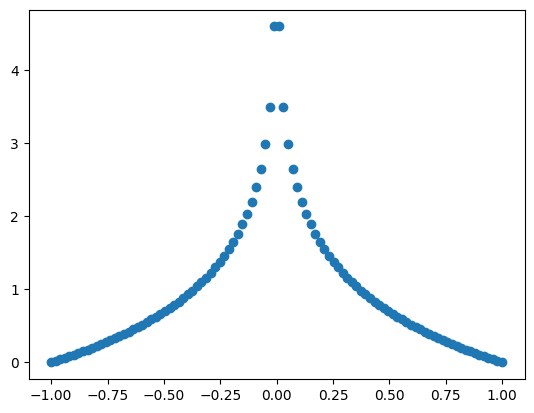

In [41]:
plt.scatter(x,-y)

In [58]:
x = np.linspace(-1,1,100)
y = np.arccos(abs(x))

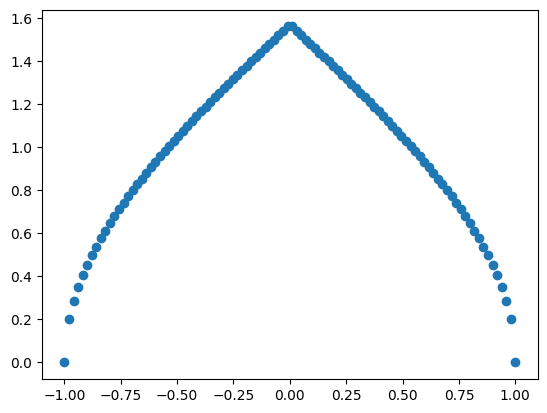

In [59]:
plt.scatter(x,y)